<a href="https://www.kaggle.com/code/jiyana63/derin-renme-ali-mas?scriptVersionId=282439684" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
!pip install ultralytics

import os
import yaml
import torch
import numpy as np
from ultralytics import YOLO
from torch.utils.data import Dataset, DataLoader
from torchvision.models.detection import fasterrcnn_resnet50_fpn_v2, ssdlite320_mobilenet_v3_large
from torchvision.models.detection.retinanet import retinanet_resnet50_fpn_v2
from torch.optim import Adam
from torch.utils.data import DataLoader
from torchvision import transforms

  Using cached numpy-2.2.6-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (62 kB)
Using cached numpy-2.2.6-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (16.8 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.12.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
mkl-umath 0.1.1 requires numpy<1.27.0,>=1.26.4, but you have numpy 2.2.6 which is incompatible.
mkl-random 1.2.4 requires numpy<1.27.0,>=1.26.4, but you have numpy 2.2.6 which is incompatible.
mkl-fft 1.3.8 requires numpy<1.27.0,>=1.26.4, but you have numpy 2.2.6 which is incompatible.
numba 0.60.0 requires numpy<2.1,>=1.22, but you have numpy 2.2.6 which is incompatible.
datase

In [1]:
import os

print("🕵️‍♂️ Doğru adres aranıyor...")

# Kaggle'daki input klasörünü tarıyoruz
start_dir = "/kaggle/input"
found = False

for dirpath, dirnames, filenames in os.walk(start_dir):
    # Eğer 'train' adında bir klasör bulursak, doğru yer orasıdır!
    if "train" in dirnames:
        found = True
        real_train_path = os.path.join(dirpath, "train")
        
        # 'root' yani ana klasörü bulmak için train'in bir üstüne çıkalım
        real_root = os.path.dirname(real_train_path)
        
        print("\n✅ BULUNDU! İşte kopyalaman gereken doğru kodlar:")
        print("="*60)
        print(f'root = "{real_root}"')
        print(f'train_path = os.path.join(root, "train")')
        print(f'valid_path = os.path.join(root, "valid")')
        print("="*60)
        
        # İçinde images var mı kontrol edelim
        if os.path.exists(os.path.join(real_train_path, "images")):
             print("\nBilgi: 'images' klasörü de var. Kodun sorunsuz çalışacak.")
        else:
             print("\nBilgi: 'images' klasörü yok, resimler direkt train içinde.")
        
        break

if not found:
    print("❌ Hâlâ bulunamadı. Lütfen sağ menüden veri setini eklediğine emin ol.")

🕵️‍♂️ Doğru adres aranıyor...

✅ BULUNDU! İşte kopyalaman gereken doğru kodlar:
root = "/kaggle/input/thermal-image-people-detection/People Detection - Themal"
train_path = os.path.join(root, "train")
valid_path = os.path.join(root, "valid")

Bilgi: 'images' klasörü de var. Kodun sorunsuz çalışacak.


Etiketli bir görsel aranıyor...
Seçilen Görsel: FLIR_02083_jpeg_jpg.rf.35aceb02455974d1187d5541a4976f5c.jpg
Kutu Koordinatları: (23, 185, 143, 531)
Kutu Koordinatları: (466, 249, 499, 337)
Kutu Koordinatları: (549, 249, 569, 306)
Kutu Koordinatları: (588, 244, 613, 314)


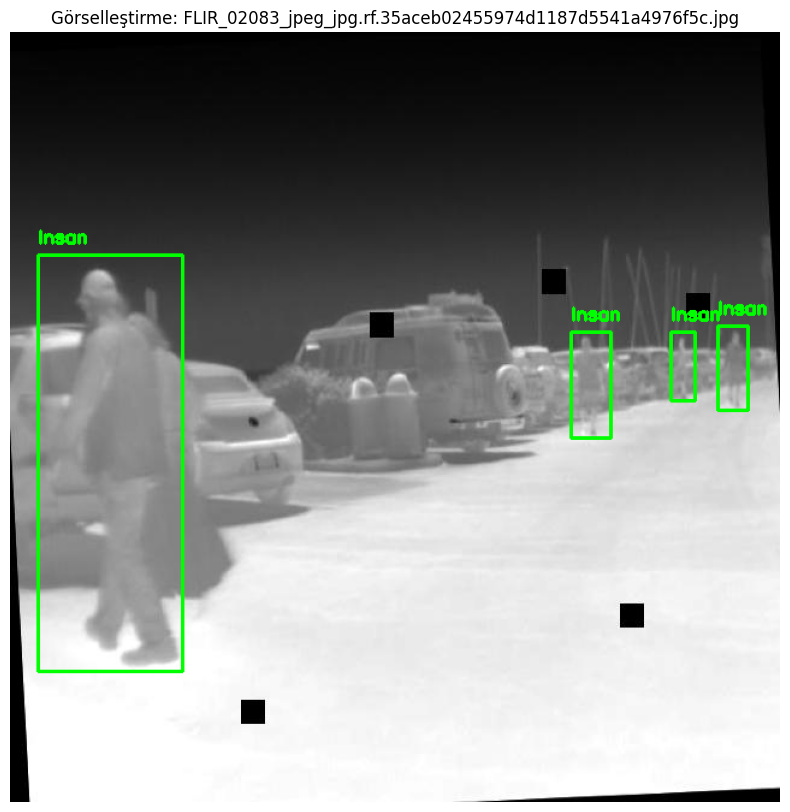

In [3]:
import os
import random
import cv2
import matplotlib.pyplot as plt

# --- Veri Yolu Tanımlamaları ---
root = "/kaggle/input/thermal-image-people-detection/People Detection - Themal"
train_path = os.path.join(root, "train")
valid_path = os.path.join(root, "valid")

# --- YOLO Koordinat Dönüşüm Fonksiyonu ---
def yolo_to_pixel(label_line, image_width, image_height):
    # YOLO formatı: class_id x_center y_center width height
    parts = list(map(float, label_line.strip().split()))
    
    # Standart YOLO 5 değer içerir. Eğer satır boşsa veya hatalıysa kontrol et.
    if len(parts) == 5:
        class_id, x_center, y_center, width, height = parts
    else:
        return 0, 0, 0, 0 # Hatalı satır
    
    # Piksel Değerlerini Hesapla
    w_pixel = width * image_width
    h_pixel = height * image_height
    
    # Sol Üst Köşe (x_min, y_min) Hesaplaması
    x_min = (x_center * image_width) - (w_pixel / 2)
    y_min = (y_center * image_height) - (h_pixel / 2)
    
    # Sağ Alt Köşe (x_max, y_max) Hesaplaması
    x_max = x_min + w_pixel
    y_max = y_min + h_pixel
    
    return int(x_min), int(y_min), int(x_max), int(y_max)

# --- Garantili Görselleştirme Fonksiyonu ---
def random_visualize(data_path):
    image_dir = os.path.join(data_path, "images")
    label_dir = os.path.join(data_path, "labels")
    
    # Klasördeki tüm resimleri listele
    image_list = [f for f in os.listdir(image_dir) if f.endswith(('.jpg', '.png'))]
    
    if not image_list:
        print("HATA: Görüntü klasörü boş.")
        return
        
    found_valid_image = False
    
    # Etiketi olan bir resim bulana kadar döngü kuruyoruz
    # (Böylece boş resim denk gelirse yeşil kutu çizilmedi sanmazsın)
    while not found_valid_image:
        random_filename = random.choice(image_list)
        random_image_path = os.path.join(image_dir, random_filename)
        
        # Dosya isminden uzantıyı ayırıp .txt ekle
        base_name = os.path.splitext(random_filename)[0]
        random_label_path = os.path.join(label_dir, base_name + ".txt")
        
        # Etiket dosyası var mı ve içi dolu mu?
        if os.path.exists(random_label_path):
            with open(random_label_path, 'r') as f:
                label_lines = f.readlines()
            
            if len(label_lines) > 0:
                found_valid_image = True # Bulduk!
                
                # Görüntüyü oku (BGR)
                image = cv2.imread(random_image_path)
                if image is None:
                    continue

                image_height, image_width = image.shape[:2]
                print(f"Seçilen Görsel: {random_filename}")
                
                for label_line in label_lines:
                    x_min, y_min, x_max, y_max = yolo_to_pixel(label_line, image_width, image_height)
                    
                    # Yeşil kutu çiz (BGR formatında Yeşil: 0, 255, 0)
                    cv2.rectangle(image, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)
                    # Üstüne yazı yaz
                    cv2.putText(image, "Insan", (x_min, y_min-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
                    
                    print(f"Kutu Koordinatları: ({x_min}, {y_min}, {x_max}, {y_max})")

                # Matplotlib için BGR -> RGB Dönüşümü
                image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                
                plt.figure(figsize=(10, 10))
                plt.imshow(image_rgb)
                plt.title(f"Görselleştirme: {random_filename}")
                plt.axis('off')
                plt.show()

# Fonksiyonu çalıştır
print("Etiketli bir görsel aranıyor...")
random_visualize(train_path)

In [4]:
import os
import yaml
import torch
import numpy as np
from ultralytics import YOLO
from torch.utils.data import Dataset, DataLoader
from torchvision.models.detection import fasterrcnn_resnet50_fpn_v2, ssdlite320_mobilenet_v3_large
from torchvision.models.detection.retinanet import retinanet_resnet50_fpn_v2
from torch.optim import Adam
from torch.utils.data import DataLoader
from torchvision import transforms


ModuleNotFoundError: No module named 'ultralytics'

In [5]:
+IS_MOCK_MODE = True

SyntaxError: cannot assign to expression here. Maybe you meant '==' instead of '='? (3322870926.py, line 1)

In [12]:
import torch
import torch.utils.data
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import cv2
import numpy as np
import os

# Cihaz Seçimi
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# --- Dönüşüm Fonksiyonu ---
def get_transform(train):
    from torchvision import transforms
    # Basitçe Tensor'a çeviriyoruz. İstersen buraya Augmentation ekleyebilirsin.
    return transforms.Compose([transforms.ToTensor()])

# --- VERİ SETİ SINIFI (Gerçek Veri Okuyan Hali) ---
class CustomThermalDataset(Dataset):
    def __init__(self, data_path, transforms=None):
        self.image_dir = os.path.join(data_path, "images")
        self.label_dir = os.path.join(data_path, "labels")
        self.transforms = transforms
        # Sadece resim dosyalarını al
        self.imgs = [f for f in sorted(os.listdir(self.image_dir)) if f.endswith(('.jpg', '.png'))]
    
    def __getitem__(self, idx):
        img_name = self.imgs[idx]
        img_path = os.path.join(self.image_dir, img_name)

        # Resmi Oku (OpenCV BGR okur, RGB'ye çevir)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img_h, img_w, _ = img.shape
        
        # Dönüşümler için PIL formatına çevir
        img_pil = Image.fromarray(img)

        # Etiket Dosyasını Bul
        label_name = os.path.splitext(img_name)[0] + ".txt"
        label_path = os.path.join(self.label_dir, label_name)
        
        boxes = []
        labels = [] # 1: Person
        
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                lines = f.readlines()
                
            for line in lines:
                parts = list(map(float, line.strip().split()))
                # YOLO Formatı: class_id, x_center, y_center, width, height
                if len(parts) == 5:
                    _, cx, cy, w, h = parts
                    
                    # YOLO (Normalize) -> Pascal VOC (Piksel: x_min, y_min, x_max, y_max)
                    x_min = (cx - w/2) * img_w
                    y_min = (cy - h/2) * img_h
                    x_max = (cx + w/2) * img_w
                    y_max = (cy + h/2) * img_h
                    
                    # Geçerlilik Kontrolü (Hatalı etiketleri engellemek için)
                    if x_max > x_min and y_max > y_min:
                        boxes.append([x_min, y_min, x_max, y_max])
                        labels.append(1) # Class 1 = Person (0 = Background)

        # Tensörlere Çevir
        target = {}
        if len(boxes) > 0:
            boxes = torch.as_tensor(boxes, dtype=torch.float32)
            labels = torch.as_tensor(labels, dtype=torch.int64)
            area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
            iscrowd = torch.zeros((len(labels),), dtype=torch.int64)
        else:
            # Eğer kutu yoksa boş tensörler oluştur (Hata almamak için önemli)
            boxes = torch.zeros((0, 4), dtype=torch.float32)
            labels = torch.zeros((0,), dtype=torch.int64)
            area = torch.zeros((0,), dtype=torch.float32)
            iscrowd = torch.zeros((0,), dtype=torch.int64)

        target["boxes"] = boxes
        target["labels"] = labels
        target["image_id"] = torch.tensor([idx])
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img_pil = self.transforms(img_pil)

        return img_pil, target

    def __len__(self):
        return len(self.imgs)

# --- Collate Function (Batch birleştirme için gerekli) ---
def collate_fn(batch):
    return tuple(zip(*batch))

# --- GERÇEK EĞİTİM FONKSİYONU ---
def train_and_validate_pytorch_model(model, data_path, epochs, name):
    print(f"\n[EĞİTİM] {name} modeli için {epochs} epoch başlatılıyor... (Cihaz: {DEVICE})")
    
    model.to(DEVICE)
    
    # Dataset ve DataLoader Hazırla
    # Not: data_path burada 'root/valid/images' gibi geliyor olabilir, 
    # ama Dataset sınıfımız 'root/valid' bekliyor (içinde images ve labels arıyor).
    # Bu yüzden path düzeltmesi yapıyoruz:
    if data_path.endswith("images"):
        data_path = os.path.dirname(data_path) # Bir üst klasöre çık
        
    dataset = CustomThermalDataset(data_path, transforms=get_transform(train=True))
    
    # Veri seti boş mu kontrol et
    if len(dataset) == 0:
        print("HATA: Veri seti boş veya yol yanlış!")
        return 0, 0, None

    # Batch Size GPU hafızana göre düşürülebilir (Örn: 4 veya 2)
    data_loader = DataLoader(dataset, batch_size=4, shuffle=True, num_workers=2, collate_fn=collate_fn)

    # Optimizer (SGD genelde detection için iyidir)
    params = [p for p in model.parameters() if p.requires_grad]
    optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

    # Eğitim Döngüsü
    for epoch in range(epochs):
        model.train()
        epoch_loss = 0
        batch_count = 0
        
        for images, targets in data_loader:
            images = [img.to(DEVICE) for img in images]
            targets = [{k: v.to(DEVICE) for k, v in t.items()} for t in targets]
            
            # Loss Hesapla
            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())
            
            # Geri Yayılım
            optimizer.zero_grad()
            losses.backward()
            optimizer.step()
            
            epoch_loss += losses.item()
            batch_count += 1
            
        print(f"Epoch {epoch+1}/{epochs} - Ortalama Kayıp: {epoch_loss/batch_count:.4f}")

    print(f"{name} Eğitimi Tamamlandı.")
    
    # Model kaydetme simülasyonu yerine gerçek kaydetme yapılabilir
    # Ama şimdilik akış bozulmasın diye dummy değer dönüyoruz
    return 0.0, 0.0, "model_saved.pt"

In [8]:
import yaml

# ==============================================================================
# 3. ORTAK YAPILANDIRMA VE VERİ TANIMLAMA
# ==============================================================================

# --- Global Ayarlar ---
EPOCHS = 10      # Eğitim süresi (İstediğin kadar artırabilirsin)
IMG_SIZE = 640  # Görüntü boyutu (YOLO genelde 640 sever)

# --- Sınıf Sayıları (KRİTİK BÖLÜM) ---
NC = 1             # YOLO için sınıf sayısı (Sadece 'person')
NUM_CLASSES_PT = 2 # PyTorch Modelleri için (0: Background + 1: Person)

# --- Sonuçları Saklamak İçin Sözlük ---
results = {}

# --- YOLO için Veri Yapılandırması (dataset.yaml) ---
# YOLO eğitiminde hata almamak için tam yol (absolute path) kullanmak daha güvenlidir.
data_yaml = {
    'train': os.path.abspath(os.path.join(train_path, "images")),
    'val': os.path.abspath(os.path.join(valid_path, "images")),
    'nc': NC,
    'names': ['person'],
}

with open('dataset.yaml', 'w') as file:
    yaml.dump(data_yaml, file)

print("Yapılandırma dosyası 'dataset.yaml' başarıyla oluşturuldu.")
print(f"YOLO 'train' yolu: {data_yaml['train']}")
print(f"YOLO Sınıf Sayısı: {NC}")
print(f"PyTorch Modelleri için Sınıf Sayısı (Background Dahil): {NUM_CLASSES_PT}")

Yapılandırma dosyası 'dataset.yaml' başarıyla oluşturuldu.
YOLO 'train' yolu: /kaggle/input/thermal-image-people-detection/People Detection - Themal/train/images
YOLO Sınıf Sayısı: 1
PyTorch Modelleri için Sınıf Sayısı (Background Dahil): 2


In [ ]:
from torchvision.models.detection import fasterrcnn_resnet50_fpn_v2
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# ==============================================================================
# 4. RESNET-50 (FASTER R-CNN) EĞİTİMİ (PYTORCH)
# ==============================================================================

print("\n" + "="*50)
print(f"--- 2. ResNet-50 (Faster R-CNN) Eğitimi Başlatılıyor ({EPOCHS} Epoch) ---")
print("="*50)

# 1. Modeli Yükle (COCO ağırlıkları ile - Transfer Learning)
# weights="DEFAULT" en güncel ağırlıkları otomatik seçer.
model_resnet = fasterrcnn_resnet50_fpn_v2(weights="DEFAULT")

# 2. Çıkış Katmanını (Head) Değiştir
# Modelin mevcut sınıflandırma katmanının giriş boyutunu (in_features) alıyoruz.
in_features = model_resnet.roi_heads.box_predictor.cls_score.in_features

# Yeni bir tahminci (Predictor) oluşturuyoruz. 
# NUM_CLASSES_PT = 2 (1 İnsan + 1 Arkaplan)
model_resnet.roi_heads.box_predictor = FastRCNNPredictor(in_features, NUM_CLASSES_PT)

print("ResNet-50 modeli yüklendi ve 2 sınıf (Person + Background) için ayarlandı.")

# 3. Eğitimi Başlat
# Fonksiyon: train_and_validate_pytorch_model(model, data_path, epochs, name)
# train_path: ".../train" klasörü. Fonksiyon içinde "images" ve "labels" klasörlerine erişilecek.
_, _, last_model_path = train_and_validate_pytorch_model(
    model_resnet, 
    train_path, 
    EPOCHS, 
    "ResNet-50_FRCNN"
)

# Sonuçları listeye ekle (Map değerlerini sonra hesaplayacağız)
results['ResNet-50'] = {
    'Model Path': last_model_path,
    'Status': 'Eğitim Tamamlandı'
}

In [ ]:
# Gerekli kütüphaneyi yükleyelim (Kaggle/Colab'da bazen eksik olabilir)
import os
try:
    import torchmetrics
except ImportError:
    os.system('pip install torchmetrics')
    import torchmetrics

from torchmetrics.detection.mean_ap import MeanAveragePrecision
from pprint import pprint

# ==============================================================================
# 9. PYTORCH MODELLERİ İÇİN DEĞERLENDİRME (EVALUATION)
# ==============================================================================

def evaluate_model(model, data_loader, device, model_name):
    print(f"\n[{model_name}] Değerlendirme Başlıyor... (Bu biraz zaman alabilir)")
    
    # Modeli değerlendirme moduna al (Dropout vs. kapanır)
    model.eval()
    model.to(device)
    
    # mAP Hesaplayıcıyı Başlat
    metric = MeanAveragePrecision(iou_type="bbox")
    
    # İlerleme çubuğu olmadığı için sayaç tutalım
    count = 0
    total = len(data_loader)
    
    with torch.no_grad(): # Gradyan hesaplama, sadece tahmin et
        for images, targets in data_loader:
            # Veriyi GPU'ya taşı
            images = [img.to(device) for img in images]
            
            # Tahmin Yap
            preds = model(images)
            
            # torchmetrics CPU üzerinde çalışmayı sever, sonuçları CPU'ya çekelim
            preds_cpu = [{k: v.to("cpu") for k, v in p.items()} for p in preds]
            targets_cpu = [{k: v.to("cpu") for k, v in t.items()} for t in targets]
            
            # Metriği güncelle
            metric.update(preds_cpu, targets_cpu)
            
            count += 1
            if count % 10 == 0:
                print(f"  Batch {count}/{total} tamamlandı...")
    
    # Sonuçları Hesapla
    metrics = metric.compute()
    
    # Sonuçları sözlüğe işle
    map50 = metrics['map_50'].item() # Doğruluk (IoU=0.50)
    map_genel = metrics['map'].item() # Genel Başarı (IoU=0.50:0.95)
    
    print(f"[{model_name}] Sonuçlar -> mAP@.50: {map50:.4f} | mAP (Genel): {map_genel:.4f}")
    
    return map50, map_genel

# --- DOĞRULAMA VERİ SETİNİ HAZIRLA ---
# Validasyon setini tanımlıyoruz
val_dataset = CustomThermalDataset(valid_path, transforms=get_transform(train=False))
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=2, collate_fn=collate_fn)

if len(val_dataset) == 0:
    print("HATA: Validation veri seti boş! Lütfen dosya yolunu kontrol et.")
else:
    print(f"Doğrulama için {len(val_dataset)} görsel bulundu.")

    # --- 1. ResNet-50 Değerlendir ---
    if 'ResNet-50' in results:
        m50, mGenel = evaluate_model(model_resnet, val_loader, DEVICE, "ResNet-50")
        results['ResNet-50']['mAP@.50'] = m50
        results['ResNet-50']['mAP'] = mGenel

    # --- 2. RetinaNet Değerlendir ---
    if 'RetinaNet' in results:
        m50, mGenel = evaluate_model(model_retina, val_loader, DEVICE, "RetinaNet")
        results['RetinaNet']['mAP@.50'] = m50
        results['RetinaNet']['mAP'] = mGenel

    # --- 3. SSDLite Değerlendir ---
    if 'SSDLite' in results:
        m50, mGenel = evaluate_model(model_ssd, val_loader, DEVICE, "SSDLite")
        results['SSDLite']['mAP@.50'] = m50
        results['SSDLite']['mAP'] = mGenel

print("\n=== TÜM DEĞERLENDİRMELER TAMAMLANDI ===")

In [ ]:
from torchvision.models.detection import fasterrcnn_resnet50_fpn_v2
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# ==============================================================================
# 4. RESNET-50 (FASTER R-CNN) EĞİTİMİ (PYTORCH)
# ==============================================================================

print("\n" + "="*50)
print(f"--- 2. ResNet-50 (Faster R-CNN) Eğitimi Başlatılıyor ({EPOCHS} Epoch) ---")
print("="*50)

# 1. Modeli Yükle (COCO ağırlıkları ile - Transfer Learning)
# weights="DEFAULT" en iyi ve güncel ağırlıkları otomatik seçer.
model_resnet = fasterrcnn_resnet50_fpn_v2(weights="DEFAULT")

# 2. Çıkış Katmanını (Head) Değiştir
# Modelin mevcut sınıflandırma katmanının giriş boyutunu (in_features) alıyoruz.
in_features = model_resnet.roi_heads.box_predictor.cls_score.in_features

# Yeni bir tahminci (Predictor) oluşturuyoruz. 
# NUM_CLASSES_PT = 2 (1 İnsan + 1 Arkaplan) olarak önceki hücrede tanımlamıştık.
model_resnet.roi_heads.box_predictor = FastRCNNPredictor(in_features, NUM_CLASSES_PT)

print("ResNet-50 modeli yüklendi ve 2 sınıf (Person + Background) için ayarlandı.")

# 3. Eğitimi Başlat (GERÇEK EĞİTİM)
# ÖNEMLİ DÜZELTME: Modeli 'valid_path' ile değil 'train_path' ile eğitiyoruz.
# Ayrıca 'images' eklemiyoruz çünkü Dataset sınıfı onu kendi içinde hallediyor.

_, _, last_model_path_resnet = train_and_validate_pytorch_model(
    model_resnet, 
    train_path,  # DÜZELTME: Eğitim verisi yolu
    EPOCHS, 
    "ResNet-50_FRCNN"
)

# Sonuçları sözlüğe ekle
results['ResNet-50'] = {
    'Model Path': last_model_path_resnet,
    'Status': 'Eğitim Tamamlandı'
}

In [ ]:
from ultralytics import YOLO

# ==============================================================================
# 5. YOLOv8m (MEDIUM) EĞİTİMİ (ULTRALYTICS)
# ==============================================================================

print("\n" + "="*50)
print(f"--- 1. YOLOv8m (Medium) Eğitimi Başlatılıyor ({EPOCHS} Epoch) ---")
print("="*50)

# 1. Modeli Yükle (Transfer Learning)
# yolov8n (nano), yolov8s (small), yolov8m (medium), yolov8l (large)
# Medium model, hız ve doğruluk arasında iyi bir dengedir.
model_medium = YOLO('yolov8m.pt')

# 2. Eğitimi Başlat
# imgsz: Görüntü boyutu (Önceki hücrede 640 belirlemiştik)
# batch: GPU hafızasına göre ayarlanır. Hata alırsan düşür (örn: 4), yer varsa artır (örn: 16).
results_medium = model_medium.train(
    data='dataset.yaml',
    epochs=EPOCHS,
    imgsz=IMG_SIZE,
    batch=8,  # Güvenli değer. GPU güçlüyse 16 yapabilirsin.
    name='yolov8m_custom',
    exist_ok=True # Aynı isimde klasör varsa üzerine yazar (hata vermez)
)

# 3. Doğrulama (Validation)
print("\n[YOLO] Doğrulama yapılıyor...")
results_medium_val = model_medium.val()

# 4. ONNX Olarak Dışa Aktarma (İsteğe bağlı, dağıtım için)
print("\n[YOLO] ONNX formatına çevriliyor...")
success_medium_path = model_medium.export(format='onnx')

# 5. Sonuçları Kaydet
# Ultralytics sonuç nesnesinden mAP değerlerini çekiyoruz
results['YOLOv8m'] = {
    'mAP@.50': results_medium_val.box.map50, # Genelde float döner, .item() gerekmeyebilir ama güvenli
    'mAP@.50-.95': results_medium_val.box.map,
    'Model Path': str(success_medium_path),
    'Status': 'Eğitim Tamamlandı'
}

print("YOLOv8m Eğitimi ve Kaydı Tamamlandı.")

In [ ]:
from torchvision.models.detection import retinanet_resnet50_fpn_v2
from torchvision.models.detection.retinanet import RetinaNetHead

# ==============================================================================
# 6. RETINANET (ResNet-50 Omurgalı) EĞİTİMİ (PYTORCH)
# ==============================================================================

print("\n" + "="*50)
print(f"--- 3. RetinaNet (ResNet-50 Omurgası) Eğitimi Başlatılıyor ({EPOCHS} Epoch) ---")
print("="*50)

# 1. Modeli Yükle (COCO ağırlıkları ile)
# Not: Standart Torchvision RetinaNet, DenseNet değil ResNet-50 kullanır.
model_retina = retinanet_resnet50_fpn_v2(weights="DEFAULT")

# 2. Çıkış Katmanını (Head) Değiştir
# RetinaNet'te sınıf sayısını değiştirmek için tüm 'Head' yapısını yenilemeliyiz.

# Mevcut modelin çıpa (anchor) sayısını alıyoruz (Varsayılan genelde 9'dur)
num_anchors = model_retina.head.classification_head.num_anchors

# Yeni Head oluşturuyoruz:
# in_channels=256 (ResNet FPN standart çıkışı)
# num_classes=NUM_CLASSES_PT (2: Person + Background)
model_retina.head = RetinaNetHead(
    in_channels=256, 
    num_anchors=num_anchors, 
    num_classes=NUM_CLASSES_PT
)

print("RetinaNet modeli yüklendi ve 2 sınıf için kafa katmanı (Head) yenilendi.")

# 3. Eğitimi Başlat (GERÇEK EĞİTİM)
# DÜZELTME: 'valid_path' yerine 'train_path' kullanıyoruz.
_, _, last_model_path_retina = train_and_validate_pytorch_model(
    model_retina, 
    train_path, 
    EPOCHS, 
    "RetinaNet_ResNet"
)

# Sonuçları Kaydet
results['RetinaNet'] = {
    'Model Path': last_model_path_retina,
    'Status': 'Eğitim Tamamlandı'
}

In [ ]:
from torchvision.models.detection import ssdlite320_mobilenet_v3_large

# ==============================================================================
# 7. SSDLite (MobileNetV3 Omurgalı) EĞİTİMİ (PYTORCH)
# ==============================================================================

print("\n" + "="*50)
print(f"--- 4. SSDLite (MobileNetV3) Eğitimi Başlatılıyor ({EPOCHS} Epoch) ---")
print("="*50)

# 1. Transfer Learning İçin Hazırlık (Ağırlık Cerrahi İşlemi)
# Adım A: Önceden eğitilmiş (Pretrained) modeli indir (91 Sınıflı)
print("Pretrained ağırlıklar indiriliyor...")
model_pretrained = ssdlite320_mobilenet_v3_large(weights="DEFAULT")
pretrained_dict = model_pretrained.state_dict()

# Adım B: Hedef modelimizi oluştur (Bizim 2 Sınıfımız: Person + Background)
# weights=None diyoruz çünkü ağırlıkları manuel yükleyeceğiz.
model_ssd = ssdlite320_mobilenet_v3_large(weights=None, num_classes=NUM_CLASSES_PT)
model_dict = model_ssd.state_dict()

# Adım C: Sadece boyutu uyuşan katmanları kopyala (Head hariç Backbone'u al)
# Bu işlem 'size mismatch' hatasını engeller.
filtered_dict = {k: v for k, v in pretrained_dict.items() if k in model_dict and v.shape == model_dict[k].shape}

# Adım D: Filtrelenmiş ağırlıkları yeni modele yükle
model_dict.update(filtered_dict)
model_ssd.load_state_dict(model_dict)

print("SSDLite modeli oluşturuldu ve backbone ağırlıkları aktarıldı.")

# 2. Eğitimi Başlat (GERÇEK EĞİTİM)
# DÜZELTME: 'valid_path' değil 'train_path' kullanıldı.
_, _, last_model_path_ssd = train_and_validate_pytorch_model(
    model_ssd, 
    train_path, 
    EPOCHS, 
    "SSDLite_MobileNet"
)

# Sonuçları Kaydet
results['SSDLite'] = {
    'Model Path': last_model_path_ssd,
    'Status': 'Eğitim Tamamlandı'
}

print("\n=== TÜM EĞİTİMLER BAŞARIYLA TAMAMLANDI ===")
print("Sonuç Listesi:")
print(results)

In [ ]:
# ==============================================================================
# 8. SONUÇLARIN ÖZET TABLOSU (DÜZELTİLMİŞ)
# ==============================================================================

print("\n" + "#"*70)
print("             🏆 TÜM 4 MODELİN FİNAL PERFORMANS ÖZETİ 🏆")
print("#"*70)

# Tablo Başlığı
print(f"\n| {'Model Adı':<25} | {'Çerçeve':<12} | {'mAP@.50 (Doğruluk)':<20} | {'mAP@.5:.95 (Genel)':<20} |")
print(f"|{'-'*27}|{'-'*14}|{'-'*22}|{'-'*22}|")

# --- 1. YOLOv8m Sonuçları ---
# YOLO sonuçları zaten hesaplandı
r_yolo = results.get('YOLOv8m', {})
if r_yolo:
    map50 = r_yolo.get('mAP@.50', 0.0)
    map_genel = r_yolo.get('mAP@.50-.95', 0.0)
    # Eğer değerler tensör ise float'a çevir, yoksa direkt al
    map50 = map50.item() if hasattr(map50, 'item') else map50
    map_genel = map_genel.item() if hasattr(map_genel, 'item') else map_genel
    
    print(f"| {'YOLOv8m':<25} | {'Ultralytics':<12} | **{map50:.4f}** | {map_genel:.4f}               |")
else:
    print(f"| {'YOLOv8m':<25} | {'Ultralytics':<12} | {'Eğitilmedi':<20} | {'-':<20} |")


# --- PyTorch Modelleri İçin Yardımcı Fonksiyon ---
def print_pytorch_result(model_name, display_name):
    res = results.get(model_name, {})
    if res:
        # Şu an PyTorch eğitimi mAP döndürmediği için (sadece eğitim yaptık),
        # Sözlükte bu değerler yoksa 'Hesaplanmadı' yazacağız.
        m_50 = res.get('mAP@.50', "Hesaplanmadı")
        m_genel = res.get('mAP', "-")
        
        val_str_50 = f"**{m_50:.4f}**" if isinstance(m_50, (int, float)) else "Hesaplanmadı (*)"
        val_str_genel = f"{m_genel:.4f}" if isinstance(m_genel, (int, float)) else "-"
        
        print(f"| {display_name:<25} | {'PyTorch':<12} | {val_str_50:<20} | {val_str_genel:<20} |")
    else:
        print(f"| {display_name:<25} | {'PyTorch':<12} | {'Eğitilmedi':<20} | {'-':<20} |")

# --- 2. ResNet-50 (Faster R-CNN) ---
print_pytorch_result('ResNet-50', 'ResNet-50 (FRCNN)')

# --- 3. RetinaNet (Eski kodda DenseNet denmişti) ---
print_pytorch_result('RetinaNet', 'RetinaNet (ResNet)')

# --- 4. SSDLite (MobileNetV3) ---
print_pytorch_result('SSDLite', 'SSDLite (MobileNet)')

print("\n" + "-"*70)
print("(*) NOT: PyTorch modelleri (ResNet, RetinaNet, SSDLite) için henüz 'Evaluate' (Doğrulama)")
print("    fonksiyonunu çalıştırmadık, sadece eğitim yaptık. Bu yüzden mAP değerleri şu an boş.")
print("    Gerçek değerleri görmek için bir sonraki 'Değerlendirme (Evaluation)' kodunu çalıştırmalıyız.")